In [1]:
# In this notebook, we will evaluate the results from the fully conv compression ratio experiments


In [2]:

import pathlib
import pickle
import logging
logging.basicConfig(level=logging.INFO)

from src.eval_utils import *

#base_output_dir = pathlib.Path('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output')
base_dir = pathlib.Path('../../output/lassen')
files = list(base_dir.glob('interfacial_ae_v30_*'))

print(len(files))

53


In [3]:
def read_loss_curve_from_file(outdir):
    loss_path = outdir / 'loss_history.json'
    with open(loss_path) as f:
        loss_curve = json.load(f)
    return loss_curve

Could not read ../../output/lassen/interfacial_ae_v30_run_13_datadirHEAVISIDE_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_06_datadirSIGNED_DISTANCE_EXACT_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_41_datadirTANH_EPSILON00625_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_48_datadirTANH_EPSILON0125_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_34_datadirTANH_EPSILON003125_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_20_datadirTANH_EPSILON00078125_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_27_datadirTANH_EPSILON0015625_seed4_maxtrainsamples20000
Could not read ../../output/lassen/interfacial_ae_v30_run_55_datadirTANH_EPSILON025_seed4_maxtrainsamples20000


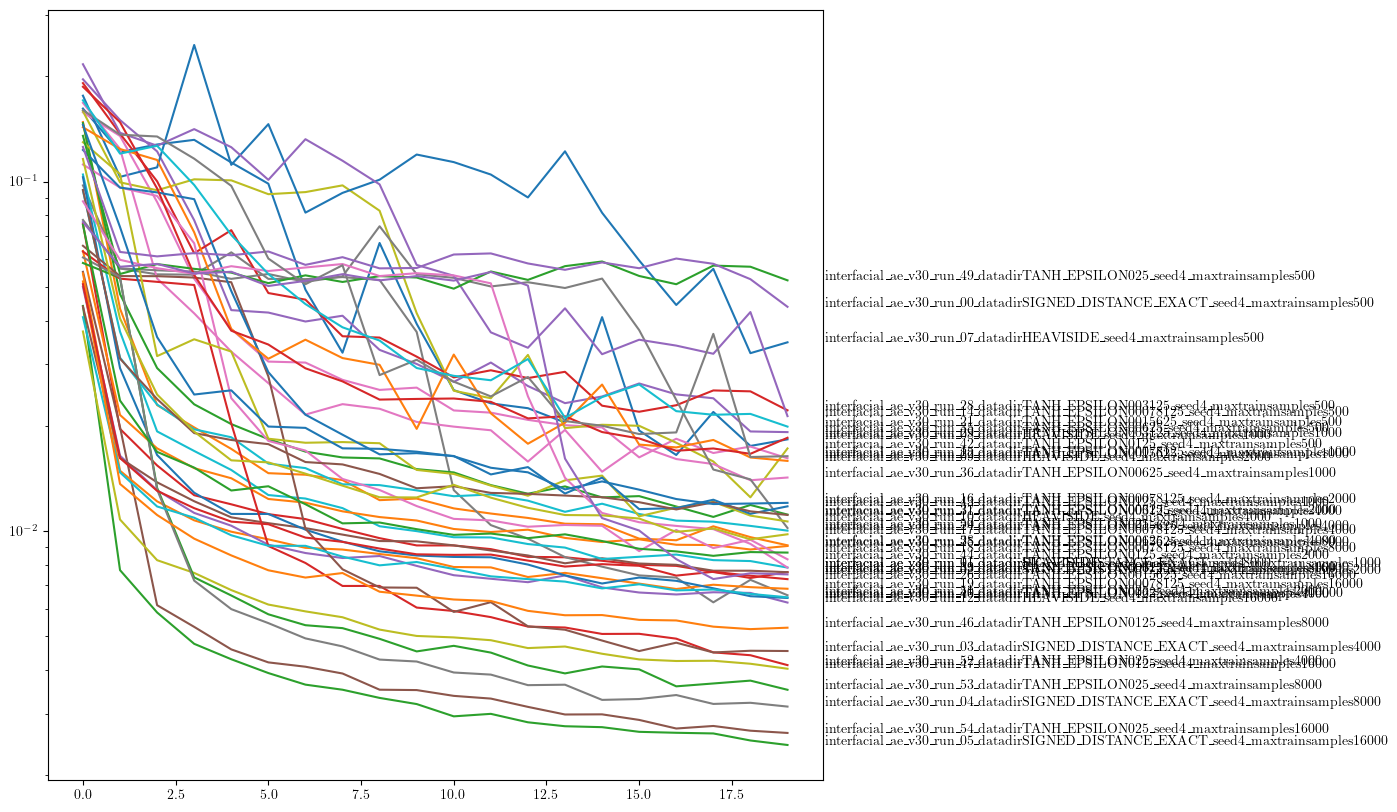

In [4]:
# Compare all the loss curves on one axis

name_to_loss = {}

for f in files:
    try:
        name_to_loss[f] = read_loss_curve_from_file(f)
    except:
        print(f'Could not read {f}')

fig, ax = plt.subplots(figsize=(10, 10))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
#ax.legend()
ax.set_yscale('log')
plt.show()



In [5]:
# Functions to group the data by interface type and epsilon

def extract_compression_ratio(outdir):
    run_info_path = outdir / 'run_info.json'
    
    with open(run_info_path) as f:
        run_info = json.load(f)
        
    return run_info['compression_ratio']


def extract_interface_type(outdir):
    
    final_part = '_'.join(outdir.stem.split('_')[5:-2])
    final_part = final_part.replace('datadir', '')

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'SIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-2])
    
    # Remove 'datadir' from start of string
    final_part = final_part.replace('datadir', '')
    
    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
        'SIGNED_DISTANCE_APPROXIMATE': None,
    }
    
    return str_to_epsilon[final_part]
    

def get_model_path(outdir):
    return outdir / 'model-20.pt'


def get_dim_mults(outdir):
    model_args_path = outdir / 'construct_model_args.json'
    
    with open(model_args_path) as f:
        model_args = json.load(f)
        
    return model_args['dim_mults']


def get_max_train_samples(outdir):
    final_part =outdir.stem.split('_')[-1]
    final_part = final_part.replace('maxtrainsamples', '')
    max_train_samples = int(final_part)
    return max_train_samples


def get_dataset_path(interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')
    
    
    

In [6]:
outdir_to_params = {}

for outdir in files:
    print(outdir.stem.split('_'))
    interfacetype = extract_interface_type(outdir)
    compression_ratio = extract_compression_ratio(outdir)
    epsilon = extract_epsilon(outdir)
    model_path = get_model_path(outdir)
    dim_mults = get_dim_mults(outdir)
    dataset_path = get_dataset_path(interfacetype, epsilon)
    max_train_samples = get_max_train_samples(outdir)

    if not model_path.exists():
        continue

    # assert model_path.exists(), f'{model_path} does not exist'
    assert dataset_path.exists(), f'{dataset_path} does not exist'
   
    params = {
       'compression_ratio': compression_ratio,
       'interface_type': interfacetype,
       'epsilon': epsilon,
       'model_path': model_path,
       'dataset_path': dataset_path,
       'dim_mults': dim_mults,
        'max_train_samples': max_train_samples,
    }
   
    outdir_to_params[outdir] = params
    
print(outdir_to_params)

['interfacial', 'ae', 'v30', 'run', '08', 'datadirHEAVISIDE', 'seed4', 'maxtrainsamples1000']
['interfacial', 'ae', 'v30', 'run', '38', 'datadirTANH', 'EPSILON00625', 'seed4', 'maxtrainsamples4000']
['interfacial', 'ae', 'v30', 'run', '05', 'datadirSIGNED', 'DISTANCE', 'EXACT', 'seed4', 'maxtrainsamples16000']
['interfacial', 'ae', 'v30', 'run', '39', 'datadirTANH', 'EPSILON00625', 'seed4', 'maxtrainsamples8000']
['interfacial', 'ae', 'v30', 'run', '35', 'datadirTANH', 'EPSILON00625', 'seed4', 'maxtrainsamples500']
['interfacial', 'ae', 'v30', 'run', '13', 'datadirHEAVISIDE', 'seed4', 'maxtrainsamples20000']
['interfacial', 'ae', 'v30', 'run', '54', 'datadirTANH', 'EPSILON025', 'seed4', 'maxtrainsamples16000']
['interfacial', 'ae', 'v30', 'run', '22', 'datadirTANH', 'EPSILON0015625', 'seed4', 'maxtrainsamples1000']
['interfacial', 'ae', 'v30', 'run', '51', 'datadirTANH', 'EPSILON025', 'seed4', 'maxtrainsamples2000']
['interfacial', 'ae', 'v30', 'run', '42', 'datadirTANH', 'EPSILON0125'

In [7]:
# Run inference for all
k = 0
for outdir, params in outdir_to_params.items():
    k += 1
    print('=' * 64)
    print(f"Dir {k} of {len(outdir_to_params)}")
    print('=' * 64)

    outfile = outdir / 'inference.npz'

    if outfile.exists():
        continue

    print(outdir)

    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000)
    model = load_model(params['model_path'], dim_mults=params['dim_mults'])
    gts, preds = run_inference(dataset, model, N=50)
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time!
    
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

Dir 1 of 45
Dir 2 of 45
Dir 3 of 45
Dir 4 of 45
Dir 5 of 45
Dir 6 of 45
../../output/lassen/interfacial_ae_v30_run_54_datadirTANH_EPSILON025_seed4_maxtrainsamples16000


INFO:src.datasets.volumetric_datasets:Found 59388 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_36.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 

Loading model to device: mps
Running inference on device: mps


  0%|          | 0/50 [00:00<?, ?it/s]/Users/murray/miniconda3/envs/mfe/lib/python3.12/site-packages/torch/nn/functional.py:4538: UserWarning: The operator 'aten::upsample_nearest3d.vec' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_nearest3d(input, output_size, scale_factors)
100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


Dir 7 of 45
Dir 8 of 45
Dir 9 of 45
../../output/lassen/interfacial_ae_v30_run_42_datadirTANH_EPSILON0125_seed4_maxtrainsamples500


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_34.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 6

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 10 of 45
Dir 11 of 45
Dir 12 of 45
Dir 13 of 45
Dir 14 of 45
Dir 15 of 45
Dir 16 of 45
Dir 17 of 45
Dir 18 of 45
Dir 19 of 45
../../output/lassen/interfacial_ae_v30_run_47_datadirTANH_EPSILON0125_seed4_maxtrainsamples16000


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_34.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 6

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Dir 20 of 45
Dir 21 of 45
../../output/lassen/interfacial_ae_v30_run_45_datadirTANH_EPSILON0125_seed4_maxtrainsamples4000


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_34.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 6

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Dir 22 of 45
Dir 23 of 45
../../output/lassen/interfacial_ae_v30_run_53_datadirTANH_EPSILON025_seed4_maxtrainsamples8000


INFO:src.datasets.volumetric_datasets:Found 59388 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_36.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Dir 24 of 45
../../output/lassen/interfacial_ae_v30_run_52_datadirTANH_EPSILON025_seed4_maxtrainsamples4000


INFO:src.datasets.volumetric_datasets:Found 59388 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_36.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Dir 25 of 45
Dir 26 of 45
Dir 27 of 45
../../output/lassen/interfacial_ae_v30_run_44_datadirTANH_EPSILON0125_seed4_maxtrainsamples2000


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_34.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 6

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Dir 28 of 45
Dir 29 of 45
Dir 30 of 45
../../output/lassen/interfacial_ae_v30_run_40_datadirTANH_EPSILON00625_seed4_maxtrainsamples16000


INFO:src.datasets.volumetric_datasets:Found 59406 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_32.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Dir 31 of 45
../../output/lassen/interfacial_ae_v30_run_43_datadirTANH_EPSILON0125_seed4_maxtrainsamples1000


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=5000
INFO:src.datasets.volumetric_datasets:Loaded 5000 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_34.npz
INFO:src.datasets.volumetric_datasets:Generated 5000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 6

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


Dir 32 of 45
Dir 33 of 45
Dir 34 of 45
Dir 35 of 45
Dir 36 of 45
Dir 37 of 45
Dir 38 of 45
Dir 39 of 45
Dir 40 of 45
Dir 41 of 45
Dir 42 of 45
Dir 43 of 45
Dir 44 of 45
Dir 45 of 45


In [8]:
# Go over each file, and load predictions, compute metrics from each volume

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    # Compute metrics
    # 2. Dice coefficient
    
    dices = []
    
    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
    }
    

../../output/lassen/interfacial_ae_v30_run_08_datadirHEAVISIDE_seed4_maxtrainsamples1000
0.7774613767654651
../../output/lassen/interfacial_ae_v30_run_38_datadirTANH_EPSILON00625_seed4_maxtrainsamples4000
0.8798838791652643
../../output/lassen/interfacial_ae_v30_run_05_datadirSIGNED_DISTANCE_EXACT_seed4_maxtrainsamples16000
0.9374500092752451
../../output/lassen/interfacial_ae_v30_run_39_datadirTANH_EPSILON00625_seed4_maxtrainsamples8000
0.8503762755147328
../../output/lassen/interfacial_ae_v30_run_35_datadirTANH_EPSILON00625_seed4_maxtrainsamples500
0.6347967245317305
../../output/lassen/interfacial_ae_v30_run_54_datadirTANH_EPSILON025_seed4_maxtrainsamples16000
0.9018499870017969
../../output/lassen/interfacial_ae_v30_run_22_datadirTANH_EPSILON0015625_seed4_maxtrainsamples1000
0.8452270203013181
../../output/lassen/interfacial_ae_v30_run_51_datadirTANH_EPSILON025_seed4_maxtrainsamples2000
0.7935267153519588
../../output/lassen/interfacial_ae_v30_run_42_datadirTANH_EPSILON0125_seed4_m

In [43]:

with open('output/trainsize_hit_outdir_to_params.pkl', 'wb') as f:
    pickle.dump(outdir_to_params, f)

with open('output/trainsize_hit_outdir_to_metrics.pkl', 'wb') as f:
    pickle.dump(outdir_to_metrics, f)

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_92771/3721105791.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(tanh_labels))


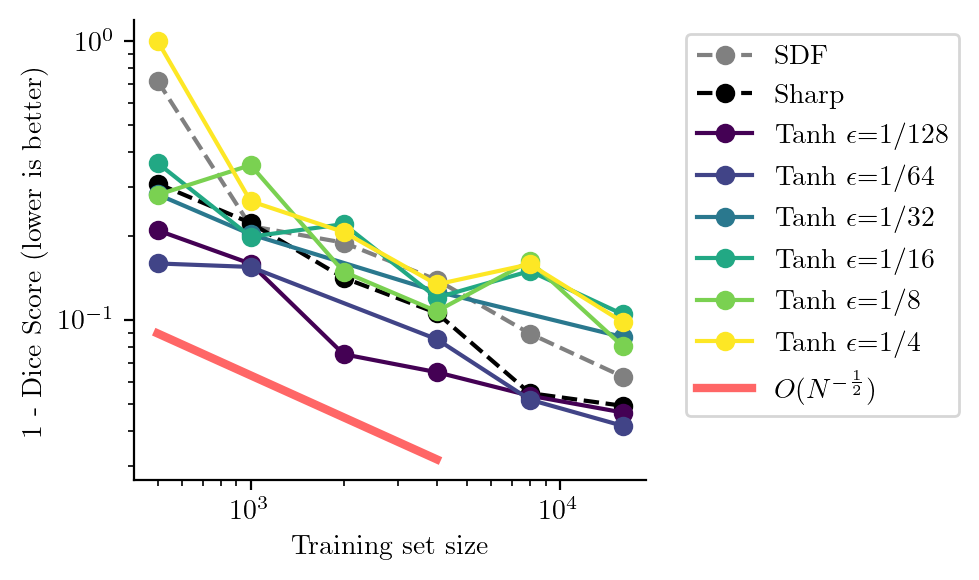

In [44]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict
from fractions import Fraction

# This helper function is from your original code
def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

# 1. Restructure the data for the new plot
# We want to group by interface type, and for each type, have a list of (num_samples, dice_scores)
plot_data = defaultdict(list)

for outdir, params in outdir_to_params.items():
    # Generate the label for the interface type, same as before
    interface_type = params['interface_type']
    epsilon = params['epsilon']

    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'Tanh $\\epsilon$={float_to_fraction(epsilon)}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else: # Heaviside
        label = 'Sharp'

    # Get the data points for this experiment
    num_samples = params['max_train_samples']
    dice_scores = outdir_to_metrics[outdir]['Dice']

    # Store the number of samples and the raw dice scores for this run
    plot_data[label].append((num_samples, dice_scores))

# 2. Prepare for plotting: sort data points and assign colors
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)

# Separate labels to control color mapping and plotting order
tanh_labels = sorted([l for l in plot_data if l.startswith('Tanh')],
                     key=lambda l: float(eval(l.split('=')[-1])))
other_labels = sorted([l for l in plot_data if not l.startswith('Tanh')])

# Create a viridis colormap for the Tanh lines
viridis = cm.get_cmap('viridis', len(tanh_labels))
colors = {label: viridis(i) for i, label in enumerate(tanh_labels)}
styles = {label: '-' for label in tanh_labels}

# Assign specific colors for other interface types
for label in other_labels:
    styles[label] = '--'
    if label == 'SDF':
        colors[label] = 'gray' # Blue
    elif label == 'Sharp':
        colors[label] = 'black' # Orange
    else:
        raise ValueError(f'Unknown label {label}')

# 3. Generate the plot
# Plot other types first, then Tanh types on top
for label in other_labels + tanh_labels:
    # Sort the data points by the number of samples for correct line plotting
    sorted_data = sorted(plot_data[label], key=lambda x: x[0])

    x_samples = [item[0] for item in sorted_data]
    y_dices_list = [item[1] for item in sorted_data]
    y_mean = [1.0 - np.mean(dices) for dices in y_dices_list]
    ax.loglog(x_samples, y_mean, marker='o', linestyle=styles[label], label=label, color=colors[label])


# Add convergence rate line
xs = np.array(x_samples[:-2], dtype=float)
ys = 2.0 * xs ** (-0.5)
ax.loglog(xs, ys, linestyle='-', lw=3, color='red', alpha=0.6, label='$O(N^{-\\frac{1}{2}})$')

# 4. Finalize plot aesthetics
ax.set_xlabel('Training set size')
ax.set_ylabel('1 - Dice Score (lower is better)')
#ax.set_title('Model Performance vs. Training Data Size by Interface Type')
#ax.set_ylim(bottom=0.85, top=1.0) # Adjust ylim to focus on the relevant range
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

plt.savefig("output/trainsize_hit.pdf")

plt.show()

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_92771/2798611201.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(tanh_labels))


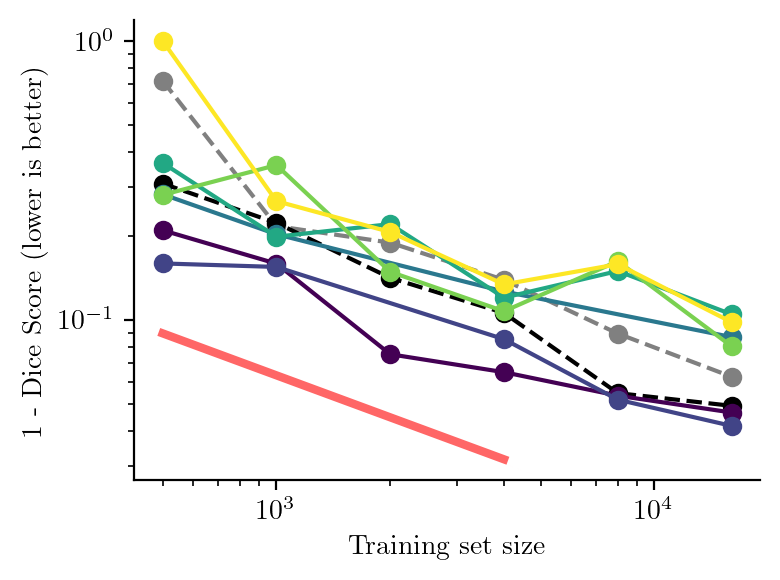

In [48]:

# 1. Restructure the data for the new plot
# We want to group by interface type, and for each type, have a list of (num_samples, dice_scores)
plot_data = defaultdict(list)

for outdir, params in outdir_to_params.items():
    # Generate the label for the interface type, same as before
    interface_type = params['interface_type']
    epsilon = params['epsilon']

    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'Tanh $\\epsilon$={float_to_fraction(epsilon)}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else: # Heaviside
        label = 'Sharp'

    # Get the data points for this experiment
    num_samples = params['max_train_samples']
    dice_scores = outdir_to_metrics[outdir]['Dice']

    # Store the number of samples and the raw dice scores for this run
    plot_data[label].append((num_samples, dice_scores))

# 2. Prepare for plotting: sort data points and assign colors
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)

# Separate labels to control color mapping and plotting order
tanh_labels = sorted([l for l in plot_data if l.startswith('Tanh')],
                     key=lambda l: float(eval(l.split('=')[-1])))
other_labels = sorted([l for l in plot_data if not l.startswith('Tanh')])

# Create a viridis colormap for the Tanh lines
viridis = cm.get_cmap('viridis', len(tanh_labels))
colors = {label: viridis(i) for i, label in enumerate(tanh_labels)}
styles = {label: '-' for label in tanh_labels}

# Assign specific colors for other interface types
for label in other_labels:
    styles[label] = '--'
    if label == 'SDF':
        colors[label] = 'gray' # Blue
    elif label == 'Sharp':
        colors[label] = 'black' # Orange
    else:
        raise ValueError(f'Unknown label {label}')

# 3. Generate the plot
# Plot other types first, then Tanh types on top
for label in other_labels + tanh_labels:
    # Sort the data points by the number of samples for correct line plotting
    sorted_data = sorted(plot_data[label], key=lambda x: x[0])

    x_samples = [item[0] for item in sorted_data]
    y_dices_list = [item[1] for item in sorted_data]
    y_mean = [1.0 - np.mean(dices) for dices in y_dices_list]
    ax.loglog(x_samples, y_mean, marker='o', linestyle=styles[label], label=label, color=colors[label])


# Add convergence rate line
xs = np.array(x_samples[:-2], dtype=float)
ys = 2.0 * xs ** (-0.5)
ax.loglog(xs, ys, linestyle='-', lw=3, color='red', alpha=0.6, label='$O(N^{-\\frac{1}{2}})$')

# 4. Finalize plot aesthetics
ax.set_xlabel('Training set size')
ax.set_ylabel('1 - Dice Score (lower is better)')
#ax.set_title('Model Performance vs. Training Data Size by Interface Type')
#ax.set_ylim(bottom=0.85, top=1.0) # Adjust ylim to focus on the relevant range
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make space for the legend

plt.savefig("output/trainsize_hit_no_legend.pdf")

plt.show()
